<a href="https://colab.research.google.com/github/WilliamAshbee/splineexample/blob/main/learnedloss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

torch.Size([100, 1]) torch.Size([100, 1]) torch.Size([100, 1000]) torch.Size([1, 1000]) torch.Size([1, 1000])


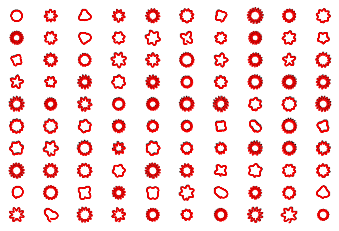

In [1]:
#i need ameba data
#i need a generator that generates ameba predictions
#i need a discriminator that takes in the picture and prediction and returns a loss
#i need to train the generator first on mses then train the discriminator on the loss mse
#i need to train a generator for single instance perfectly using the discriminator 

import torch
import numpy as np
import pylab as plt
from skimage import filters
import math

global numpoints
numpoints = 1000
side = 32

rows = torch.zeros(32,32)
columns = torch.zeros(32,32)


for i in range(32):
    columns[:,i] = i
    rows[i,:] = i


def donut_matrix(length = 10):
    radiusMax = side /3
    w = 1
    sigmas = [None, 1]
    
    canvas = torch.zeros((length,side, side))
    r0 = torch.tensor(np.random.uniform(side/4, side/3, length))

    radii = torch.zeros((length,numpoints))
    radii[:, :] = r0.unsqueeze(1)
    
    ind = [x for x in range(numpoints)]

    theta = torch.FloatTensor(ind)
    theta *= math.pi*2.0/(float)(numpoints)
    
    for i in range(1,length):
        a = np.random.uniform(1.0,3.0)*torch.sin(np.random.uniform(20.0)*theta+np.random.uniform(1000.0))
        #a = 4.0*torch.sin(10.0*theta)
        #print(a.shape,torch.max(a))
        radii[i,:] += a
        #print(radii.shape, torch.max(radii))
    
    assert torch.min(radii)>0
    #print(radii.max(axis = 0)[0].shape)
    rmaxs = radii.max(axis = 1)[0]
    pmins = rmaxs+1.0
    pmaxs = side-rmaxs-1.0
    x0 = np.random.uniform(pmins,pmaxs)
    y0 = np.random.uniform(pmins,pmaxs)
    x0[:]=side/2
    y0[:]=side/2
    x0 = torch.tensor(x0)
    y0 = torch.tensor(y0)
    
    x0 = x0.unsqueeze(1)
    y0 = y0.unsqueeze(1)
    #radii = torch.from_numpy(radii)
    xrfactors = torch.cos(theta).unsqueeze(0)
    yrfactors = torch.sin(theta).unsqueeze(0)
    
    print(x0.shape,y0.shape,radii.shape,xrfactors.shape,yrfactors.shape)

    x = (x0+(xrfactors*radii))
    y = (y0+(yrfactors*radii))
    assert x.shape == (length,numpoints)
    assert y.shape == (length,numpoints)
    assert torch.sum(x[x>(side-1)])==0 
    assert torch.sum(x[x<0])==0 
    assert torch.sum(y[y>(side-1)])==0 
    assert torch.sum(y[y<0])==0 
    
    points = torch.zeros(length,numpoints,2)
    for l in range(length):
        canvas[l,x[l,:].type(torch.LongTensor),y[l,:].type(torch.LongTensor)]=1.0
        #points[l,:,0] = x[l,:]
        #points[l,:,1] = y[l,:]
        points[l,:,0] = x[l,:]#modified for lstm discriminator
        points[l,:,1] = y[l,:]#modified for lstm discriminator 
    
    
    return {
        'canvas': canvas, 
        'points':points.type(torch.FloatTensor)}


def plot_all( sample = None, model = None, labels = None):
    img = sample[0,:,:].squeeze().cpu().numpy()
    plt.imshow(img, cmap=plt.cm.gray_r)
    if model != None:
        with torch.no_grad():
            global numpoints

            print("sample", sample.shape)
            pred = model(sample).view(1000,3)
            print('pred', pred.shape)
            predres = numpoints
            X = pred[:,0]
            Y = pred[:,1]
            
            s = [.001 for x in range(predres)]
            
            assert len(s) == predres
            c = ['red' for x in range(predres)]
            assert len(c) == predres
            Y = Y.cuda()
            X = X.cuda()
            print("type",type(X))
            ascatter = plt.scatter(Y.cpu().numpy(),X.cpu().numpy(),s = s,c = c)
            plt.gca().add_artist(ascatter)
    else:
        #print(labels.shape)

        X = labels[:,0]
        Y = labels[:,1]
        #print(X.shape)
        #print(Y.shape)
            
        s = [.001 for x in range(numpoints)]
        #print(len(s))
        c = ['red' for x in range(numpoints)]
        #print(len(c))
        ascatter = plt.scatter(Y.cpu().numpy(),X.cpu().numpy(),s = s,c = c)
        plt.gca().add_artist(ascatter)

class DonutDataset(torch.utils.data.Dataset):
    """Donut dataset."""
    def __init__(self, length = 10):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.length = length
        self.values = donut_matrix(length)
        assert self.values['canvas'].shape[0] == self.length
        assert self.values['points'].shape[0] == self.length

    def __len__(self):
        return self.length


    def __getitem__(self, idx):
        canvas = self.values["canvas"]
        
        canvas = canvas[idx,:,:]
        assert canvas.shape == (side,side)
        canvas = torch.reshape(canvas,(1,side,side))
        assert canvas.shape == (1,side,side)
        
        
        assert canvas.shape == (1,side,side)
        points = self.values["points"]
        points = points[idx,:]
        #points = points.unsqueeze(1)
        z = torch.zeros(numpoints,1)
        #print(z.shape)
        points = torch.cat([points,z], dim = 1)
        
        #print('points', points.shape)
        return canvas, points
    
    @staticmethod
    def displayCanvas(title,dataset, model):
        #model.setBatchSize(batch_size = 1)
        for i in range(100):
            sample, labels = dataset[i]
            plt.subplot(10,10,i+1)
            plot_all(sample = sample,model=model, labels = labels)
            plt.axis('off')
        plt.savefig(title,dpi=600)

    @staticmethod
    def displayCanvas2(title,x = None, pred = None):
      img = x
      #plt.imshow(img, cmap=plt.cm.gray_r)
      X = pred[0,:,0]
      Y = pred[0,:,1]
            
      s = [.1 for x in range(pred.shape[1])]
      c = ['red' for x in range(pred.shape[1])]
      ascatter = plt.scatter(Y.detach().cpu().numpy(),X.detach().cpu().numpy(),s = s,c = c)
      plt.gca().add_artist(ascatter)
      plt.savefig(title,dpi=600)

dataset = DonutDataset(length = 100)
DonutDataset.displayCanvas('donut.png',dataset, model = None)



In [2]:
import torch
import torch.nn as nn
from torch.hub import load_state_dict_from_url

class MLPGEN(nn.Module):

    def __init__(self):
        super(MLPGEN, self).__init__()
        self.hidden_dim = 1*32*32
        self.featurevector = None
        self.mlp = nn.Sequential(
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(self.hidden_dim, 3000),
            nn.Sigmoid()
        
        )
    

    def forward(self, x):
        #print(self.featurevector.shape)
        first = x.shape[0]
        x = x.reshape(first,-1)
        if x.shape != (first,self.hidden_dim):
            print('bad shape', x.shape)

        assert x.shape == (first,self.hidden_dim)
        return 32.0*self.mlp(x)


In [43]:
from torch.utils import data
from torch.utils.data import DataLoader, TensorDataset, RandomSampler

dataset_train = DonutDataset(128*10)
dataset_val = DonutDataset(128*1)

mini_batch = 64
loader_train = data.DataLoader(
    dataset_train, batch_size=mini_batch,
    sampler=RandomSampler(data_source=dataset_train),
    num_workers=4)

loader_val = data.DataLoader(
    dataset_val, batch_size=mini_batch,
    sampler=RandomSampler(data_source=dataset_val),
    num_workers=4)

model = MLPGEN()


torch.Size([1280, 1]) torch.Size([1280, 1]) torch.Size([1280, 1000]) torch.Size([1, 1000]) torch.Size([1, 1000])
torch.Size([128, 1]) torch.Size([128, 1]) torch.Size([128, 1000]) torch.Size([1, 1000]) torch.Size([1, 1000])


In [44]:
from torch.utils import data
from torch.utils.data import DataLoader, TensorDataset, RandomSampler

dataset_train = DonutDataset(128*2)
dataset_val = DonutDataset(128*1)

mini_batch = 128
loader_train = data.DataLoader(
    dataset_train, batch_size=mini_batch,
    sampler=RandomSampler(data_source=dataset_train),
    num_workers=4)

loader_val = data.DataLoader(
    dataset_val, batch_size=mini_batch,
    sampler=RandomSampler(data_source=dataset_val),
    num_workers=4)



torch.Size([256, 1]) torch.Size([256, 1]) torch.Size([256, 1000]) torch.Size([1, 1000]) torch.Size([1, 1000])
torch.Size([128, 1]) torch.Size([128, 1]) torch.Size([128, 1000]) torch.Size([1, 1000]) torch.Size([1, 1000])


In [45]:
import torch
import torch.nn as nn
from torch.hub import load_state_dict_from_url

class MLP(nn.Module):

    def __init__(self):
        super(MLP, self).__init__()
        self.hidden_dim = 1*32*32+3000
        self.featurevector = None
        self.mlp = nn.Sequential(
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(self.hidden_dim, 1),
            nn.ReLU(True)
        )


    def init_hidden(self,hidden):
        first = hidden.shape[0]
        #print('hidden',hidden.shape)
        self.featurevector = hidden.reshape(first,-1)

        return (None, None)


    def forward(self, x, predPoints):
        first = x.shape[0]
        
        #x = torch.cat([x,self.featurevector],1)
        x = torch.cat([torch.flatten(x,start_dim = 1), torch.flatten(predPoints,start_dim = 1)], 1)
        assert x.shape == (first,self.hidden_dim)
        return self.mlp(x)

In [46]:
#print(torch.flatten(x,start_dim = 1).shape)
#print(torch.flatten(predPoints,start_dim = 1).shape)

#print(torch.cat([torch.flatten(x,start_dim = 1), torch.flatten(predPoints,start_dim = 1)], 1).shape)

In [56]:
disc = MLP()
disc_opt =  torch.optim.Adam(disc.parameters(), lr=0.00001, betas=(0.5, 0.999), weight_decay=0.05)

for epoch in range(30):

  for x,y in loader_train:
    dl,l = 10 , 10
    model = MLPGEN()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.5, 0.999))
    while dl > 2.0 and l > 2.0:
      if dl>2.0:
        disc_opt.zero_grad()
        predPoints = model(x)
        predPoints = predPoints.view(-1,1000,3)
        #print(predPoints.shape)
        y = y.reshape(predPoints.shape)
        assert predPoints.shape == (mini_batch,1000,3)
        assert y.shape == (mini_batch,1000,3)
        loss = torch.mean(torch.abs(predPoints-y))
        out = disc(x,predPoints)
        loss_disc = torch.mean(torch.abs(out-loss.item()))
        loss_disc.backward()
        disc_opt.step()
        dl = loss_disc.item()
        print(dl)
      else:
        optimizer.zero_grad()
        predPoints = model(x)
        predPoints = predPoints.view(-1,1000,3)
        #print(predPoints.shape)
        y = y.reshape(predPoints.shape)
        loss = torch.mean(torch.abs(predPoints-y))
        loss.backward()
        optimizer.step()
        l = loss.item()
        print('loss', loss.item())
      print('loss disc', loss_disc.item())
      #print(loss_chamfer)
      


8.029345512390137
loss disc 8.029345512390137
4.041349411010742
loss disc 4.041349411010742
1.7339569330215454
loss disc 1.7339569330215454
2.4675374031066895
loss disc 2.4675374031066895
1.6192896366119385
loss disc 1.6192896366119385
2.0656025409698486
loss disc 2.0656025409698486
1.5718659162521362
loss disc 1.5718659162521362
1.9304231405258179
loss disc 1.9304231405258179
1.9020497798919678
loss disc 1.9020497798919678
1.5178693532943726
loss disc 1.5178693532943726
1.5161927938461304
loss disc 1.5161927938461304
1.7343333959579468
loss disc 1.7343333959579468
1.5238970518112183
loss disc 1.5238970518112183
1.7563538551330566
loss disc 1.7563538551330566
1.429947018623352
loss disc 1.429947018623352
1.553627848625183
loss disc 1.553627848625183
1.676297903060913
loss disc 1.676297903060913
1.5493093729019165
loss disc 1.5493093729019165
1.5663423538208008
loss disc 1.5663423538208008
1.6298259496688843
loss disc 1.6298259496688843
1.6751179695129395
loss disc 1.6751179695129395
1.

In [25]:
torch.rand(1)

tensor([0.0330])

In [ ]:
disc = MLP()
disc_opt =  torch.optim.Adam(disc.parameters(), lr=0.00001, betas=(0.5, 0.999), weight_decay=0.05)

for epoch in range(30):

  for x,y in loader_train:
    dl,l = 10 , 10
    model = MLPGEN()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.00001, betas=(0.5, 0.999))
    while dl > 2.0 and l > 2.0:
    
      disc_opt.zero_grad()
      optimizer.zero_grad()
      predPoints = model(x)
      predPoints = predPoints.view(-1,1000,3)
      #print(predPoints.shape)
      y = y.reshape(predPoints.shape)
      loss = torch.mean(torch.abs(predPoints-y))
      loss.backward()
      optimizer.step()
      l = loss.item()
      print('loss', loss.item())
      print('loss disc', loss_disc.item())
      #print(loss_chamfer)
      


In [ ]:
DonutDataset.displayCanvas('donut.png',dataset_val, model = model)


In [ ]:
model = MLPGEN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.5, 0.999), weight_decay=0.05)
#predPoints = model(x)
#predPoints = predPoints.view(-1,1000,3)
    


l = 10 
x,y = dataset_train[0]
while True:
  
  optimizer.zero_grad()
  predPoints = model(x)
  predPoints = predPoints.view(-1,1000,3)
  y = y.reshape(predPoints.shape)
  assert predPoints.shape == (1,1000,3)
  assert y.shape == (1,1000,3)
  out = disc(x,predPoints)
  print('out', out)

  out.backward()
  optimizer.step()
  loss = torch.mean(torch.abs(predPoints-y))
  l = out.item()
  print(loss)


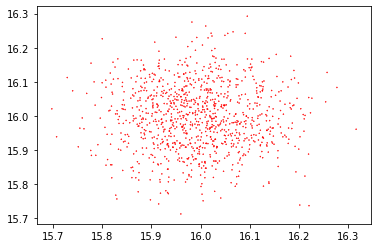

In [30]:
DonutDataset.displayCanvas2('x,prediction.png',x.reshape(32,32), predPoints)


In [11]:
print(predPoints.shape)

torch.Size([1, 1000, 3])
